In [ ]:
!pip install matplotlib==3.3.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f'PyTorch versions : {torch.__version__}')
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device : {device}')

PyTorch versions : 1.7.0+cu101
device : cuda:0


# Dataset

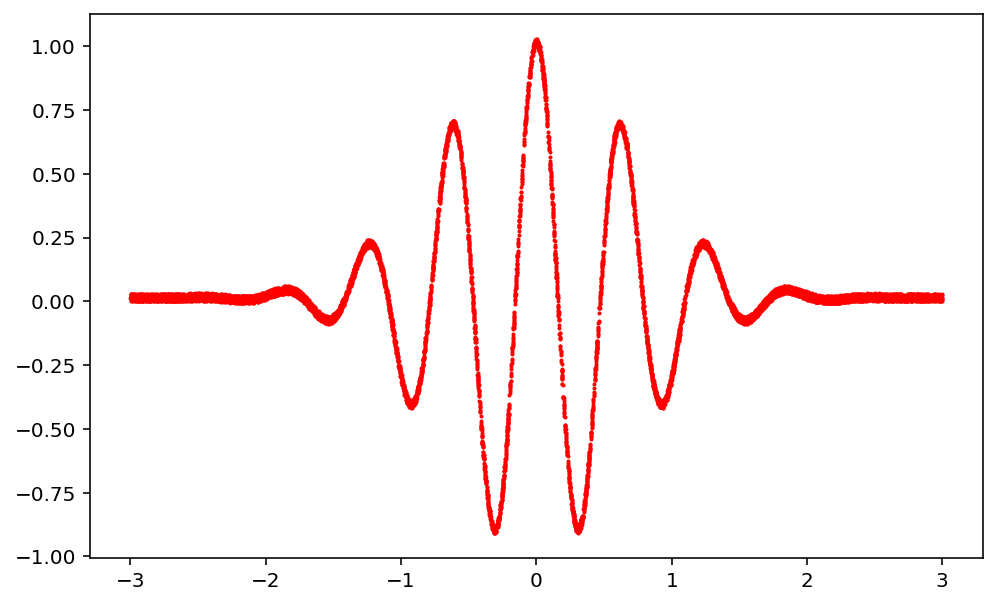

Done


In [27]:
n_data=10000
x_numpy=-3+6*np.random.rand(n_data,1)
y_numpy=np.exp(-(x_numpy**2))*np.cos(10*x_numpy)+3e-2*np.random.rand(n_data,1)
plt.figure(figsize=(8,5))
plt.plot(x_numpy,y_numpy,'r.',ms=2)
plt.show()
x_torch=torch.Tensor(x_numpy).to(device)
y_torch=torch.Tensor(y_numpy).to(device)
print('Done')

# Define Model

In [28]:
class Model(nn.Module):
    def __init__(self,name='mlp',xdim=1,hdims=[16,16],ydim=1):
        super(Model,self).__init__()
        self.name=name
        self.xdim=xdim
        self.hdims=hdims
        self.ydim=ydim

        self.layers=[]
        prev_hdim=self.xdim
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
            self.layers.append(nn.Tanh()) # activation func
            prev_hdim=hdim
        # final layer (without acitvation func)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))
        # concatenate all layers
        self.net=nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name=f'{type(layer).__name__.lower()} {l_idx}'
            self.net.add_module(layer_name,layer) # add_module : https://bit.ly/3jcj5NS
        self.init_param() # initialize parameters

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self,x):
        return self.net(x)

print('Done')

Done


In [29]:
# 동일한 네트워크, 데이터에 optimizer 바꿔서 비교
LEARNING_RATE=1e-2
# instantiate models
model_sgd=Model(name='mlp_sgd',xdim=1,hdims=[64,64],ydim=1).to(device)
model_momentum=Model(name='mlp_momentum',xdim=1,hdims=[64,64],ydim=1).to(device)
model_adam=Model(name='mlp_adam',xdim=1,hdims=[64,64],ydim=1).to(device)
# optimizers
loss=nn.MSELoss()
optm_sgd=optim.SGD(model_sgd.parameters(),lr=LEARNING_RATE)
optm_momentum=optim.SGD(model_momentum.parameters(),lr=LEARNING_RATE,momentum=0.9)
optm_adam=optim.Adam(model_adam.parameters(),lr=LEARNING_RATE)
print('Done')

Done


In [43]:
from torchsummary import summary
# 입력크기는 출력되지 않는다. 
M=Model(name='mlp_sgd',xdim=1,hdims=[64,64],ydim=1).to(device)
summary(M,input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             128
              Tanh-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              Tanh-4                   [-1, 64]               0
            Linear-5                    [-1, 1]              65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [ ]:
!pip install torchinfo

In [52]:
from torchinfo import summary

summary(M,input_size=(1,)) 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1]                       --
|    └─Linear: 2-1                       [64]                      128
|    └─Tanh: 2-2                         [64]                      --
|    └─Linear: 2-3                       [64]                      4,160
|    └─Tanh: 2-4                         [64]                      --
|    └─Linear: 2-5                       [1]                       65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1]                       --
|    └─Linear: 2-1                       [64]                      128
|    └─Tanh: 2-2                         [64]                      --
|    └─Linear: 2-3                       [64]                      4,160
|    └─Tanh: 2-4                         [64]                      --
|    └─Linear: 2-5                       [1]                       65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

# Check Parameters

In [ ]:
# 위에 summary하면 안해도 되는 문젠가?
np.set_printoptions(precision=3)
n_param=0
for p_idx,(param_name,param) in enumerate(model_sgd.named_parameters()):
    if param.requires_grad:
        param_numpy=param.detach().cpu().numpy()
        n_param+=len(param_numpy.reshape(-1))
        print(f'{p_idx} name: {param_name} {param_numpy.shape}')
        print(f'val: {param_numpy.reshape(-1)[:5]}')
print(f'total number of parameters: {n_param}')

0 name: net.linear 0.weight (64, 1)
val: [-0.034 -0.407 -0.79  -0.539  0.329]
1 name: net.linear 0.bias (64,)
val: [0. 0. 0. 0. 0.]
2 name: net.linear 2.weight (64, 64)
val: [ 0.048  0.079 -0.068 -0.164  0.12 ]
3 name: net.linear 2.bias (64,)
val: [0. 0. 0. 0. 0.]
4 name: net.linear 4.weight (1, 64)
val: [ 0.13  -0.068 -0.208 -0.173 -0.118]
5 name: net.linear 4.bias (1,)
val: [0.]
total number of parameters: 4353


# Training

In [ ]:
MAX_ITER,BATCH_SIZE,PLOT_EVERY=1e4,64,500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train() # train mode
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)): # max iter을 일부로 n_data와 같게 잡은 듯. 10000/64는 반드시 10000보다 작으니까 
    r_idx=np.random.permutation(n_data)[:BATCH_SIZE]
    batch_x,batch_y=x_torch[r_idx],y_torch[r_idx]

    # Update with Adam
    y_pred_adam=model_adam.forward(batch_x)
    loss_adam=loss(y_pred_adam,batch_y)
    optm_adam.zero_grad()
    loss_adam.backward()
    optm_adam.step()

    # Update with Momentum
    y_pred_momentum=model_momentum.forward(batch_x)
    loss_momentum=loss(y_pred_momentum,batch_y)
    optm_momentum.zero_grad()
    loss_momentum.backward()
    optm_momentum.step()
 
     # Update with SGD
    y_pred_sgd=model_sgd.forward(batch_x)
    loss_sgd=loss(y_pred_sgd,batch_y)
    optm_sgd.zero_grad()
    loss_sgd.backward()
    optm_sgd.step()

    # Plot
    if ((it&PLOT_EVERY)==0) or (it==0) or (it==(MAX_ITER-1)):
        with torch.no_grad():
            y_sgd_numpy=model_sgd.forward(x_torch).cpu().detach().numpy()
            y_momentum_numpy=model_momentum.forward(x_torch).cpu().detach().numpy()
            y_adam_numpy=model_adam.forward(x_torch).cpu().detach().numpy()
            plt.figure(figsize=(8,4))
            plt.plot(x_numpy,y_numpy,'r.',ms=4,label='GT')
            plt.plot(x_numpy,y_sgd_numpy,'g.',ms=2,label='SGD')
            plt.plot(x_numpy,y_momentum_numpy,'b.',ms=2,label='Momentum')
            plt.plot(x_numpy,y_adam_numpy,'k.',ms=2,label='ADAM')
            plt.title("[%d/%d]"%(it,MAX_ITER),fontsize=15)
            plt.legend(labelcolor='linecolor',loc='upper right',fontsize=15)
            plt.show()
print('Done')

Output hidden; open in https://colab.research.google.com to view.

# 결과 해석

* Adam : momentum + adaptive learning rate 둘다 사용해 성능 좋음
* SGD vs Momentum
    - SGD가 예측력 낮은 이유?
        - Momentum의 경우 이전의 gradient 활용해서 현재에 반영(업데이트)하는 점만 추가됨. 데이터를 한번에 더 많이 보는 효과가 있게 됨. 미니배치로 train할 때 SGD보다 성능이 좋다
        - SGD의 경우 iteration 많이 돌려야 전체 데이터가 모두 converge할때까지 갈 수 있다.
        - SGD의 한계 : mse사용한다고 했을 때 loss가 크면 많이 틀린 데를 더 많이 맞추게 되고(loss squared한 값 줄이려고 할테니까) 적게 틀린데는 오히려 덜 집중하게 됨. 만약에 outlier까지 있으면 squared loss 쓰면 bad '^' 
* Adam은 그런 momentum에 adaptive learning rate 합치므로 어느 파라미터에 대해서는 lr 늘리고 줄이고 해서 훨씬 더 빠르게 학습을 진행할 수 있다.
* 10000번 iteration에서 adam쓰면 2~3000에서 맞추는 데 반해 SGD는 만번 다돌려도 맞추지 못한 결과가 위 그래프 결과

* (교훈)optimizer에 따라 성능차이 난다. optimizer쓰려고 하면 일단 Adam부터 쓰자!